### Comparing kernel matrices with different approaches

In [30]:
using Flux,LinearAlgebra,CairoMakie,Random,ProgressMeter
Random.seed!(123)

TaskLocalRNG()

In [31]:
include("DenseNTK.jl")
include("normNTK.jl")

kernel (generic function with 2 methods)

We start by making a model using DenseNTK that works like Dense in Flux but is more general in a sense of calculating the kernel


In [32]:
Nh = 1000
model = Chain(DenseNTK(1=>Nh,relu),DenseNTK(Nh=>1))
θ = Flux.params(model)
Nx = 40
xa = -1.0
xb = 1.0
xR = range(xa,stop=xb,length=Nx) 
x = hcat(xR...)


1×40 Matrix{Float64}:
 -1.0  -0.948718  -0.897436  -0.846154  …  0.846154  0.897436  0.948718  1.0

In [34]:

K_i = zeros(Float64,3*Nh+1,Nx)
@showprogress for i = 1:Nx
    ∇_SIE = Flux.gradient(()-> model([x[i]])[1],θ)
    K_i[1:Nh,i] = ∇_SIE[θ[1]][:]
    K_i[Nh+1:2*Nh,i] = ∇_SIE[θ[2]][:]
    K_i[2*Nh+1:3*Nh,i] = ∇_SIE[θ[3]][:]
    K_i[3*Nh+1:3*Nh+1,i] = ∇_SIE[θ[4]][:] 
end

Kernel_SIE = K_i[1:3*Nh,:]'*K_i[1:3*Nh,:]
# eigen(Kernel_SIE).values

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


40×40 Matrix{Float64}:
 2.06304   2.00541   1.94846   1.89151   …  0.319605  0.302278  0.285925
 2.00541   1.95632   1.9021    1.84787      0.33482   0.318203  0.302223
 1.94846   1.9021    1.86058   1.80896      0.35099   0.334971  0.319255
 1.89151   1.84787   1.80896   1.77158      0.368143  0.352706  0.337237
 1.83155   1.79069   1.75445   1.71972      0.386952  0.372098  0.356876
 1.75342   1.71572   1.68253   1.65083   …  0.406017  0.391933  0.377147
 1.68133   1.64659   1.61624   1.58738      0.431662  0.417845  0.40299
 1.60509   1.57334   1.54587   1.51987      0.451634  0.438784  0.424563
 1.53968   1.51066   1.4858    1.4624       0.476356  0.464222  0.450382
 1.48374   1.45723   1.43477   1.41375      0.499417  0.48826   0.475062
 ⋮                                       ⋱                      
 0.448307  0.459319  0.47195   0.485663     1.50588   1.53513   1.55497
 0.423916  0.435762  0.449118  0.463538     1.56249   1.59443   1.61662
 0.398753  0.411165  0.424975  0.439834

In [35]:
K = kernel(model,x,true)


Computing kernel: 100%|██████████████████████████████████████████████████| Time: 0:00:02


40×40 Matrix{Float64}:
 2.06304   2.00541   1.94846   1.89151   …  0.319605  0.302278  0.285925
 2.00541   1.95632   1.9021    1.84787      0.33482   0.318203  0.302223
 1.94846   1.9021    1.86058   1.80896      0.35099   0.334971  0.319255
 1.89151   1.84787   1.80896   1.77158      0.368143  0.352706  0.337237
 1.83155   1.79069   1.75445   1.71972      0.386952  0.372098  0.356876
 1.75342   1.71572   1.68253   1.65083   …  0.406017  0.391933  0.377147
 1.68133   1.64659   1.61624   1.58738      0.431662  0.417845  0.40299
 1.60509   1.57334   1.54587   1.51987      0.451634  0.438784  0.424563
 1.53968   1.51066   1.4858    1.4624       0.476356  0.464222  0.450382
 1.48374   1.45723   1.43477   1.41375      0.499417  0.48826   0.475062
 ⋮                                       ⋱                      
 0.448307  0.459319  0.47195   0.485663     1.50588   1.53513   1.55497
 0.423916  0.435762  0.449118  0.463538     1.56249   1.59443   1.61662
 0.398753  0.411165  0.424975  0.439834

In [17]:
round.(K[:,:],digits=13)==round.(Kernel_SIE[:,:],digits=13)

false

In [36]:
# eigen(Kernel_SIE).values
λ = eigen(K).values
λ = abs.(λ)
λ = sort!(λ)



for i = 1:Nx
    if λ[i] == 0
        λ[i] = 10^(-19)
    end
end

λ

40-element Vector{Float64}:
  0.002195171123202441
  0.002260083961624297
  0.002373988887631638
  0.0030287906380992054
  0.0031000356697640508
  0.0033915090544632204
  0.00399697800005295
  0.004009839804460447
  0.004221754958020003
  0.004826119348193108
  ⋮
  0.04825434920730386
  0.0631246266425057
  0.07757989724149085
  0.132687284773564
  0.2220927266818571
  0.44207883854317137
  1.5894892533030822
 13.76777333571177
 37.971667964086

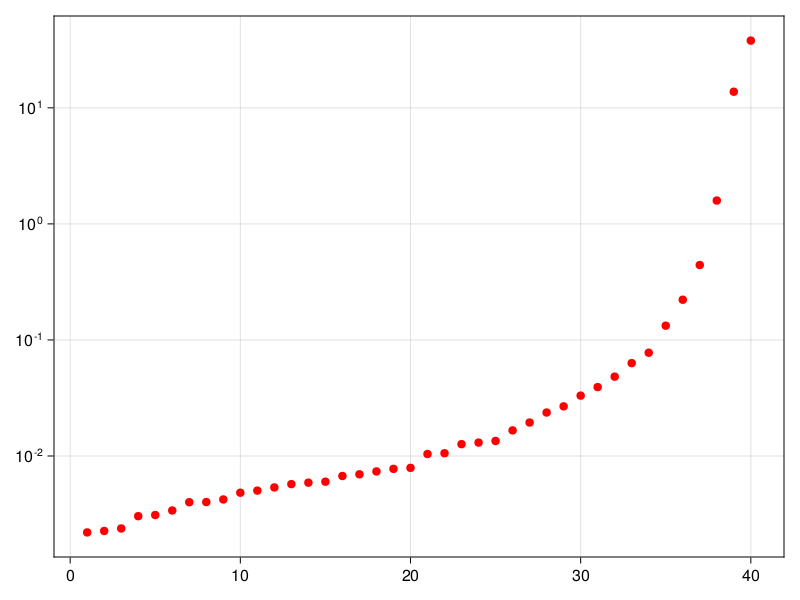

In [37]:
fig = Figure()
ax1 = Axis(fig[1,1],yscale=log10)
s1 = CairoMakie.scatter!(ax1,λ[:],color=:red)
fig


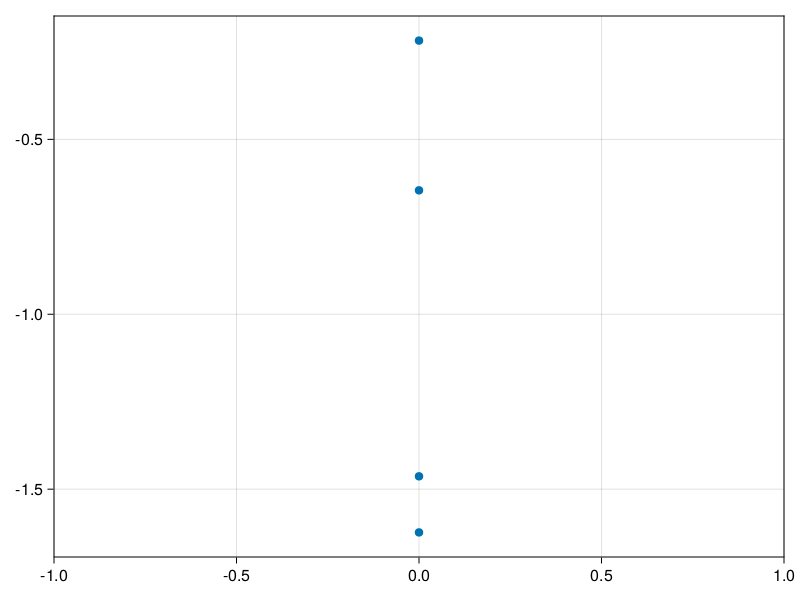

In [38]:
t = [0]
fig = Figure()
ax1 = Axis(fig[1,1])
CairoMakie.scatter!(ax1,t,θ[1][1:4])
fig



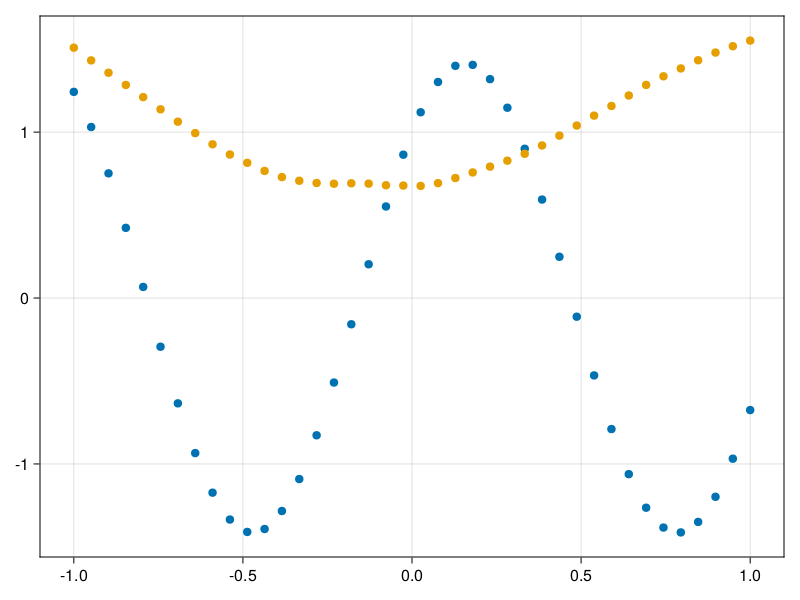

In [39]:
x_train = x
f = x->sin(5*x)+cos(5*x)
y_train = map(f,x_train)
y_hat = model(x_train)
fig = Figure()
ax1 = Axis(fig[1,1])
CairoMakie.scatter!(ax1,x_train[:],y_train[:])
CairoMakie.scatter!(ax1,x_train[:],y_hat[:])
fig


In [40]:
y_train_hat = model(x_train)
Loss(model,x,y) = Flux.mse(y,model(x))
loss = Loss(model,x_train,y_train)
train_data = [(x_train,y_train)]
display(loss)



2.6301074343479565

In [41]:

train_data = [(x_train,y_train)]
η = 1/λ[end]
Nepoch = 100_000
L = []


layer = 3
θ_stop = 6
θ_s = zeros(Nepoch,θ_stop)
@showprogress for epoch = 1:Nepoch
    Flux.train!(Loss,model,train_data,Descent(η))
    for i = 1:θ_stop
        θ_s[epoch,i] = Flux.params(model)[layer][i]
    end
        
    push!(L,Loss(model,x_train,y_train))
end



Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


In [42]:
L = hcat(L...)

1×100000 Matrix{Float64}:
 2.34465  2.11415  1.92787  1.77715  …  0.00581503  0.00581495  0.00581486

In [43]:
t = 1:Nepoch
dt = hcat(t...)



1×100000 Matrix{Int64}:
 1  2  3  4  5  6  7  8  9  10  11  12  …  99996  99997  99998  99999  100000

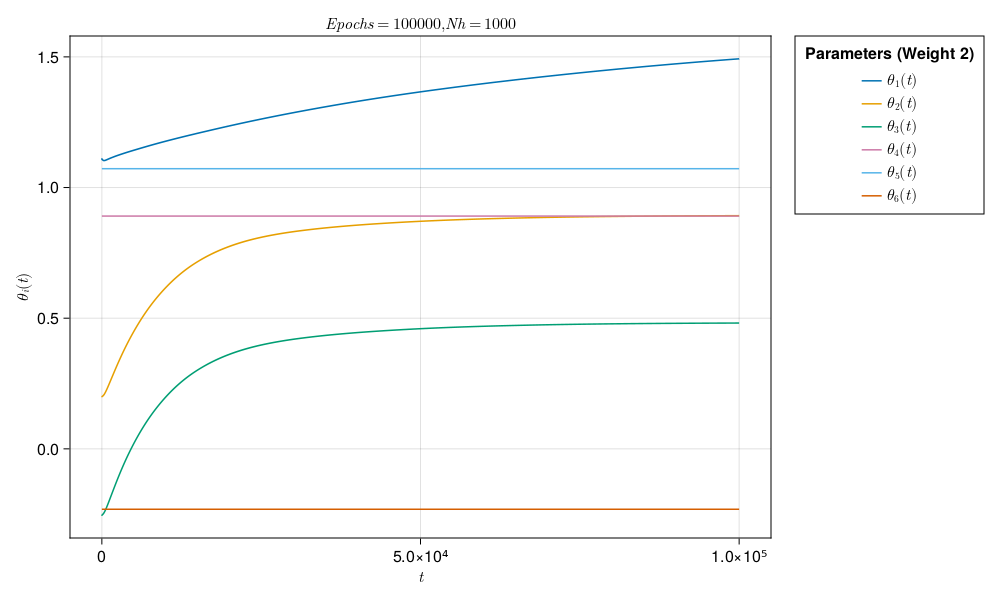

In [44]:
fig = Figure(resolution=(1000, 600))

# Creating a grid layout for the figure: 1 row, 2 columns
# The first column for the plot, the second for the legend
grid = fig[1, 1] = GridLayout()
ax1 = Axis(grid[1, 1], title=L"Epochs = %$Nepoch, Nh = %$Nh", xlabel=L"t", ylabel=L"θ_i(t)")

# Plotting data
for i = 1:θ_stop
    lines!(ax1, dt[:], θ_s[:,i], label=L"θ_{%$i}(t)")
end

# Adjusting the layout to leave space for the legend outside the plot
grid[1, 2] = Legend(fig, ax1, "Parameters (Weight 2)", valign=:top, orientation=:vertical)


fig

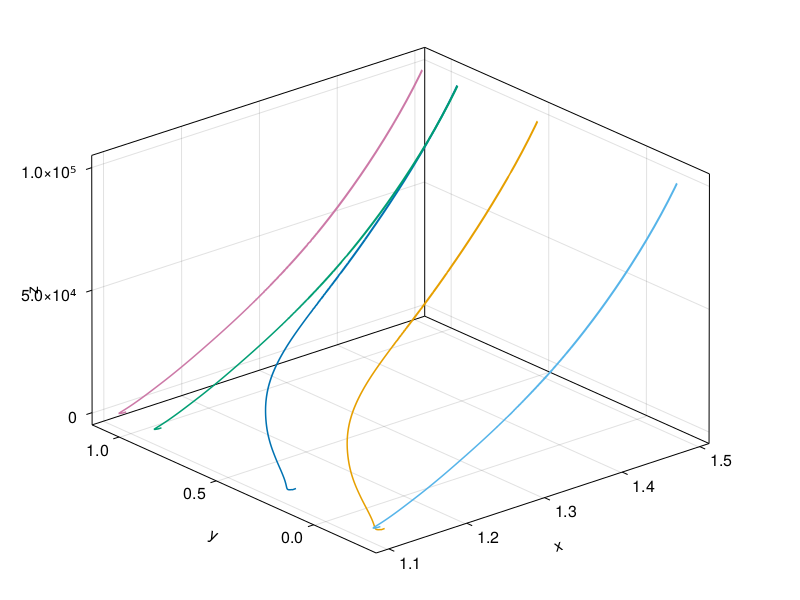

In [45]:
fig = Figure()

ax3d = Axis3(fig[1,1])

for i = 2:θ_stop
    CairoMakie.lines!(θ_s[:,1],θ_s[:,i],dt[:],label=L"%$i")
end


fig

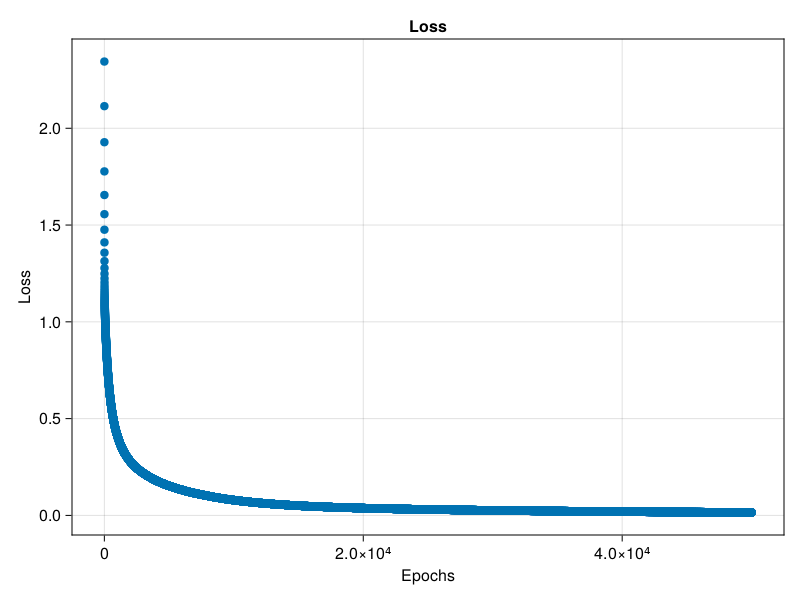

In [28]:
fig = Figure()
ax1 = Axis(fig[1,1],title = "Loss",xlabel="Epochs",ylabel="Loss")
CairoMakie.scatter!(ax1,dt[:],L[:])


fig


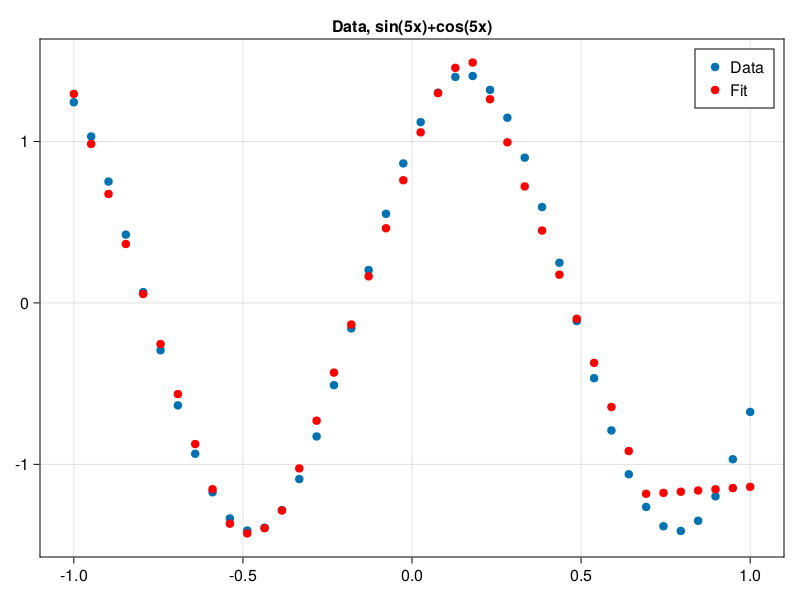

In [29]:
fig = Figure()
ax1 = Axis(fig[1,1],title = "Data, sin(5x)+cos(5x)")
CairoMakie.scatter!(ax1,x_train[:],y_train[:],label="Data")
CairoMakie.scatter!(ax1,x_train[:],model(x_train)[:],color=:red,label="Fit")
axislegend(ax1,position=:rt)
fig


In [30]:
using CairoMakie
using FileIO

# Define the function to create a plot frame
function create_frame(epoch, θ_s, L, frame_number)
    fig = Figure(resolution = (1000, 600))
    grid = fig[1, 1] = GridLayout()
    ax1 = Axis(grid[1, 1], title = "Model Parameters over Epochs", xlabel = "Epoch", ylabel = "Parameter Value")

    # Plot parameter changes up to the current epoch
    for i = 1:size(θ_s, 2)  # Assuming θ_s has dimensions [epoch, parameter]
        lines!(ax1, 1:epoch, θ_s[1:epoch, i], label = "θ_$i")
    end

    # Adjusting layout for legend, if needed
    # grid[1, 2] = Legend(fig, ax1, "Parameters", valign = :top, orientation = :vertical)

    # Save the frame
    filename = string("frame_", lpad(frame_number, 4, '0'), ".png")
    save(filename, fig)
end

# Assuming your training loop and data collection are already set up
# Inside your training loop, at certain intervals, call `create_frame`
frame_number = 1
for epoch = 1:Nepoch
    # Your training and data collection code here

    if epoch % 100 == 0  # Adjust the interval as needed
        create_frame(epoch, θ_s, L, frame_number)
        frame_number += 1
    end
end

# After training, compile the frames into a GIF
frames = [string("frame_", lpad(i, 4, '0'), ".png") for i = 1:frame_number-1]
gif_filename = "parameter_changes.gif"
save(gif_filename, frames, fps = 10)  # Adjust fps as needed


┌ Warning: Mapping to the storage type failed; perhaps your data had out-of-range values?
│ Try `map(clamp01nan, img)` to clamp values to a valid range.
└ @ ImageMagick C:\Users\trist\.julia\packages\ImageMagick\KDZC2\src\ImageMagick.jl:179
Error encountered while save File{DataFormat{:GIF}, String}("parameter_changes.gif").

Fatal error:


CapturedException: MethodError: no method matching mapIM(::String)

Closest candidates are:
  mapIM(!Matched::FixedPointNumbers.Normed)
   @ ImageMagick C:\Users\trist\.julia\packages\ImageMagick\KDZC2\src\ImageMagick.jl:321
  mapIM(!Matched::AbstractFloat)
   @ ImageMagick C:\Users\trist\.julia\packages\ImageMagick\KDZC2\src\ImageMagick.jl:320
  mapIM(!Matched::ColorTypes.RGBA{T}) where T<:FixedPointNumbers.Normed
   @ ImageMagick C:\Users\trist\.julia\packages\ImageMagick\KDZC2\src\ImageMagick.jl:314
  ...

Stacktrace:
  [1] (::ImageMagick.var"#42#43"{typeof(identity)})(x::String)
    @ ImageMagick C:\Users\trist\.julia\packages\ImageMagick\KDZC2\src\ImageMagick.jl:177
  [2] iterate
    @ .\generator.jl:47 [inlined]
  [3] _collect
    @ .\array.jl:802 [inlined]
  [4] collect_similar(cont::Vector{String}, itr::Base.Generator{Vector{String}, ImageMagick.var"#42#43"{typeof(identity)}})
    @ Base .\array.jl:711
  [5] map(f::Function, A::Vector{String})
    @ Base .\abstractarray.jl:3263
  [6] image2wand(img::Any, mapi::typeof(identity), quality::Nothing, permute_horizontal::Bool; kwargs::Base.Pairs{Symbol, Int64, Tuple{Symbol}, NamedTuple{(:fps,), Tuple{Int64}}})
    @ ImageMagick C:\Users\trist\.julia\packages\ImageMagick\KDZC2\src\ImageMagick.jl:177
  [7] image2wand
    @ C:\Users\trist\.julia\packages\ImageMagick\KDZC2\src\ImageMagick.jl:174 [inlined]
  [8] #save_#39
    @ C:\Users\trist\.julia\packages\ImageMagick\KDZC2\src\ImageMagick.jl:162 [inlined]
  [9] save_
    @ C:\Users\trist\.julia\packages\ImageMagick\KDZC2\src\ImageMagick.jl:161 [inlined]
 [10] save(imagefile::File, args::Any; key_args::Base.Pairs{Symbol, Int64, Tuple{Symbol}, NamedTuple{(:fps,), Tuple{Int64}}})
    @ ImageMagick C:\Users\trist\.julia\packages\ImageMagick\KDZC2\src\ImageMagick.jl:126
 [11] #invokelatest#2
    @ .\essentials.jl:821 [inlined]
 [12] invokelatest
    @ .\essentials.jl:816 [inlined]
 [13] action(call::Symbol, libraries::Vector{Union{Base.PkgId, Module}}, file::Formatted, args::Vector{String}; options::Base.Pairs{Symbol, Int64, Tuple{Symbol}, NamedTuple{(:fps,), Tuple{Int64}}})
    @ FileIO C:\Users\trist\.julia\packages\FileIO\BE7iZ\src\loadsave.jl:219
 [14] action
    @ C:\Users\trist\.julia\packages\FileIO\BE7iZ\src\loadsave.jl:196 [inlined]
 [15] action(call::Symbol, libraries::Vector{Union{Base.PkgId, Module}}, sym::Symbol, file::String, args::Vector{String}; options::Base.Pairs{Symbol, Int64, Tuple{Symbol}, NamedTuple{(:fps,), Tuple{Int64}}})
    @ FileIO C:\Users\trist\.julia\packages\FileIO\BE7iZ\src\loadsave.jl:185
 [16] action
    @ C:\Users\trist\.julia\packages\FileIO\BE7iZ\src\loadsave.jl:185 [inlined]
 [17] #save#20
    @ C:\Users\trist\.julia\packages\FileIO\BE7iZ\src\loadsave.jl:129 [inlined]
 [18] top-level scope
    @ c:\Programming\Github\UROP\Phase3\Kernel_Comp.ipynb:38

In [ ]:
train_data = [(x_train,y_train)]
η = 1/λ[end]
Nepoch = 50000
L = []


@showprogress for epoch = 1:Nepoch
    Flux.train!(Loss,model,train_data,Descent(η))
    push!(L,Loss(model,x_train,y_train))
end

In [91]:
N = 10
l = [2.02; 1.08; 0.9; 0.01]
e_vec = []

# Calculate e_vec based on l
for ls in l
    e = N / ls
    push!(e_vec, e)
end

for i in 1:N
    element = findCorrespondingElement(i, e_vec, l)
    if !isnothing(element)
        println("Iteration $i calls element $element from vectorB")
    else
        println("Iteration $i exceeds all thresholds")
    end
    # Here you can do something with `element`
end


Iteration 1 calls element 2.02 from vectorB
Iteration 2 calls element 2.02 from vectorB
Iteration 3 calls element 2.02 from vectorB
Iteration 4 calls element 2.02 from vectorB
Iteration 5 calls element 1.08 from vectorB
Iteration 6 calls element 1.08 from vectorB
Iteration 7 calls element 1.08 from vectorB
Iteration 8 calls element 1.08 from vectorB
Iteration 9 calls element 1.08 from vectorB
Iteration 10 calls element 0.9 from vectorB


In [131]:
Nepoch = 500
epoch_vec = []
for λs in λ
    Δ = Nepoch/λs
    push!(epoch_vec,Δ)
end
epoch_vec = sort!(epoch_vec)
train_data = [(x_train,y_train)]
Loss(model,x,y) = Flux.mse(y,model(x))
L = []

loss = Loss(model,x_train,y_train)
λ = sort!(λ,rev=true)
@showprogress for epoch = 1:Nepoch
    # Determine the index for λ based on the current epoch
    index = findfirst(threshold -> epoch <= threshold, epoch_vec)
    index = isnothing(index) ? length(λ) : index  # Use the last λ if beyond all thresholds
    
    η = 1 / λ[index]  # Update learning rate based on the current epoch range
    
    display(η)
    # # Train the model with the updated learning rate
    Flux.train!(Loss, model, train_data, Descent(η))
    
    # # Record the loss
    # push!(L, Loss(model, x_train, y_train))
end



0.02633542463675313

0.02633542463675313

0.02633542463675313

0.02633542463675313

0.02633542463675313

0.02633542463675313

0.02633542463675313

0.02633542463675313

0.02633542463675313

0.02633542463675313

0.02633542463675313

0.02633542463675313

0.02633542463675313

0.07263338635929843

0.07263338635929843

0.07263338635929843

0.07263338635929843

0.07263338635929843

0.07263338635929843

0.07263338635929843

0.07263338635929843

0.07263338635929843

0.07263338635929843

0.07263338635929843

0.07263338635929843

0.07263338635929843

0.07263338635929843

0.07263338635929843

0.07263338635929843

0.07263338635929843

0.07263338635929843

0.07263338635929843

0.07263338635929843

0.07263338635929843

0.07263338635929843

0.07263338635929843

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

0.6291329104125255

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

2.2620399639471653

DomainError: DomainError with Loss is Inf on data item 1, stopping training:
